# Simple Bayesian Inference Examples

In [10]:
import jax.numpy as jnp
from jax import random
from jax.scipy.special import logsumexp
from jax import grad
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Lets set up a linear regression problem and get samples from the likelihood function. First we produce the data

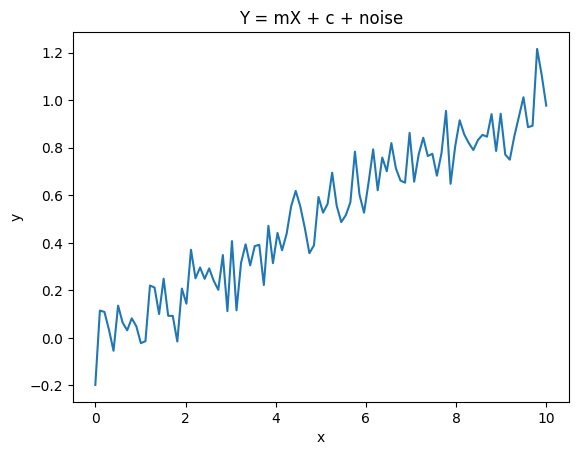

In [3]:
key = random.PRNGKey(0)

m = 0.1
c = 0
X = jnp.linspace(0,10,100)
noise_amount = 0.1
eps = noise_amount*random.normal(key, X.shape)

Y = m*X + c + eps

plt.plot(X,Y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Y = mX + c + noise")
plt.show()

### Linear Regressor Model

Here we create the model. All we need is a class that has a `logpdf` function that takes in a dictionary of data and outputs the logpdf

In [4]:
class LinearRegressor:
    def __init__(self, X, Y, noise=1):
        self.X = X
        self.Y = Y
        self.noise = noise

    def logpdf(self, x):
        Z = (self.Y - x['m']*self.X - x['c'])/self.noise
        return jnp.sum(-(Z**2))/2 

__Instantiate the model__

In [5]:
LR = LinearRegressor(X,Y,noise=noise_amount)  # Instantiate the model

Set starting point of the NUTS sampler to some point specified as a dictionary. Then initialize the NUTS sampler

In [6]:
from quicksampler import NUTS
import jax

initial_position = {'m':0.0, 'c':1.0} # starting point of the NUTS sampler
problem = NUTS(LR, initial_position)

__Run the results__

In [7]:
result = problem.run(1000)

Running the inference for 1000 samples


In [12]:
df = pd.DataFrame(result)
df

,m,c
0,0.103061,-0.013709
1,0.103323,-0.011630
2,0.105348,-0.018875
3,0.105896,-0.039735
4,0.108621,-0.031321
...,...,...
995,0.104327,-0.025296
996,0.105400,-0.005010
997,0.105913,-0.027444
998,0.099664,0.005911


array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'c'}>]],
      dtype=object)

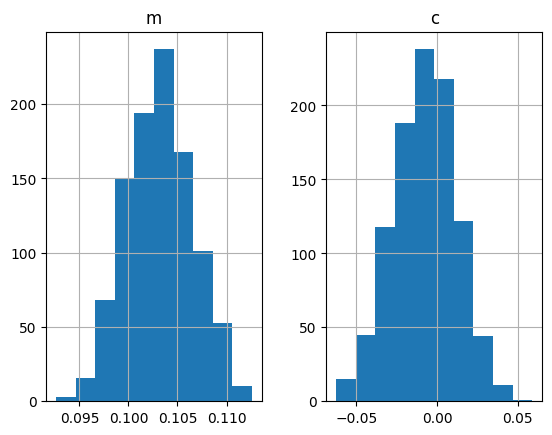

In [13]:
df.hist()

The chain will be returned as a dataframe. We can now create a traceplot and a histogram of the parameters

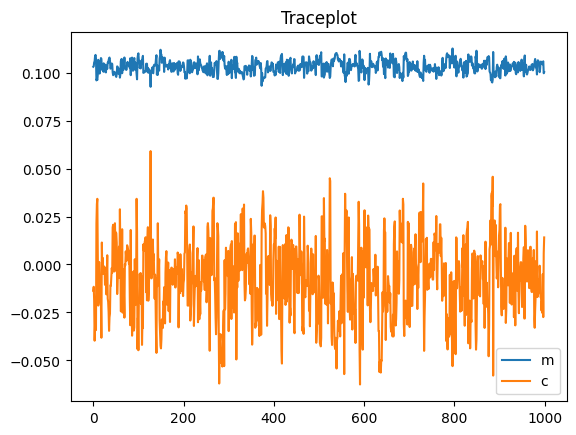

In [14]:
df.plot(title="Traceplot");

## Inferring coin flip bias with the Metropolis Hastings Sampler & numpy

Same thing again, lets generate some data. We'll do 100 experiments of 10 flips each using a biased coin with parameter $p$

In [50]:
import jax
import jax.numpy as jnp
import scipy

N_experiments = 100
N_flips = 10
p = 0.7

rv = scipy.stats.binom(N_flips, p)
head_counts = rv.rvs(N_experiments)

Now lets define our coin flip model:

In [51]:
class CoinFlip:
    def __init__(self, N_flips, number_of_heads):
        self.head_counts = number_of_heads 
        self.N_flips = N_flips

    def logpdf(self, x):
        p = x['p']
        return jnp.sum( jax.scipy.stats.binom.logpmf(self.head_counts, self.N_flips, p) )

In [52]:
from quicksampler import NUTS, MHSampler

CF = CoinFlip(10, head_counts)

initial_position = {'p':0.1} # starting point of the NUTS sampler
problem2 = MHSampler(CF, initial_position, limits={'p': [0,1]}, step_size=0.1, backend='numpy');

In [53]:
result2 = problem2.run(1000);

Getting 1000 using Metropolis Hastings


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 293.00it/s]

Sampling finished with an acceptance rate of 60.79


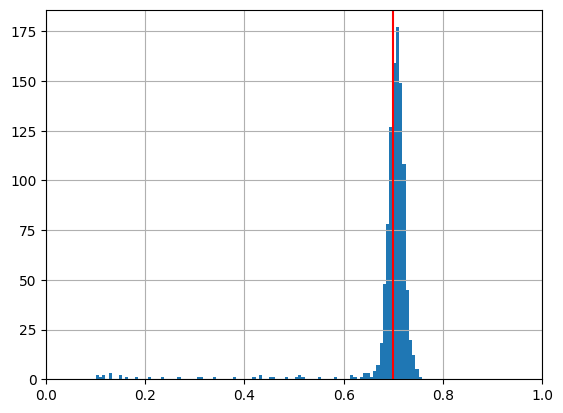

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
result = pd.DataFrame(result2)

result['p'].hist(bins=100)
plt.xlim((0,1))
plt.axvline(p, c='r')
plt.show()

## Inferring coin flip bias with the Metropolis Hastings sampler and JAX

In [55]:
CF = CoinFlip(10, head_counts)

initial_position = {'p':0.1} # starting point of the NUTS sampler
problem2 = MHSampler(CF, initial_position, limits={'p': [0,1]}, step_size=0.1, backend='JAX');

In [56]:
result2 = problem2.run(1000);

Getting 1000 using Metropolis Hastings


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 285.28it/s]


Sampling finished with an acceptance rate of 72.15


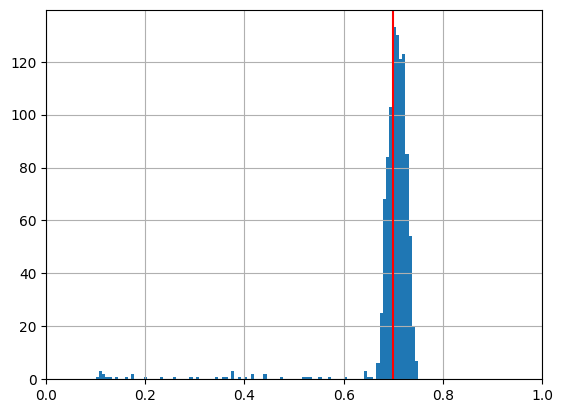

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
result = pd.DataFrame(result2)

result['p'].hist(bins=100)
plt.xlim((0,1))
plt.axvline(p, c='r')
plt.show()

## Inferring coin flip bias with the NUTS sampler

In [58]:
CF = CoinFlip(10, head_counts)

initial_position = {'p':0.1} # starting point of the NUTS sampler
problem2 = NUTS(CF, initial_position, limits={'p': [0,1], 'mu': [0.0, 1.0]}, step_size=0.1);

In [59]:
result2 = problem2.run(1000);

Running the inference for 1000 samples


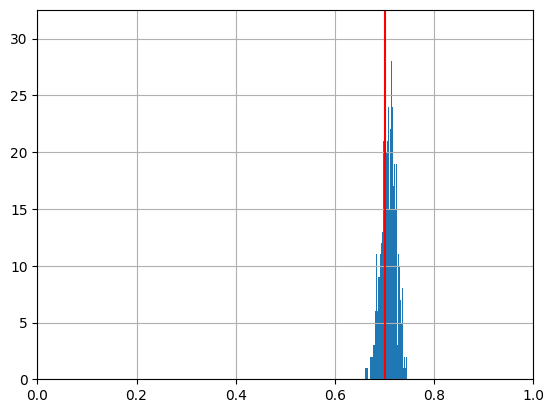

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
result = pd.DataFrame(result2)

result['p'].hist(bins=100)
plt.xlim((0,1))
plt.axvline(p, c='r')
plt.show()